In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import time, pdb, pickle, argparse, shutil, yaml, torch, math, time, pdb, datetime, pickle, sys
import utils #file
from solver_encoder import Solver 
from torch.backends import cudnn
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import torch.nn.functional as F
import importlib

In [2]:
# tailor config, define other 
model_name = 'TrueVtesNoCd16Freq32NeckTrainingDataOnly150-300kIters'
cudnn.benchmark = True
convert_style = True
use_avg_vte = False
autovc_model_saves_dir = '/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/'
autovc_model_dir = autovc_model_saves_dir + model_name
config = pickle.load(open(autovc_model_dir +'/config.pkl','rb'))
ckpt_iters = 300000
config.which_cuda = 0
config.autovc_ckpt = autovc_model_dir +'/ckpts/ckpt_' +str(ckpt_iters) +'.pth.tar'
avg_embs = np.load(os.path.dirname(config.emb_ckpt) +'/averaged_embs.npy')
config.vte_ckpt = '/homes/bdoc3/phonDet/results/newStandardAutovcSpmelParamsUnnormLatent64Out256/best_epoch_checkpoint.pth.tar'
# additional config attrs
style_names = ['belt','lip_trill','straight','vocal_fry','vibrato','breathy']
singer_names = ['m1_','m2_','m3_','m4_','m5_','m6_','m7_','m8_','m9_','m10_','m11_','f1_','f2_','f3_','f4_','f5_','f6_','f7_','f8_','f9_']
test_names = pickle.load(open(os.path.dirname(config.emb_ckpt) +'/config_params.pkl', 'rb')).test_list.split(' ')
# config.exclude_list = [item for item in singer_names if item not in test_names]
male_idx = range(0,11)
female_idx = range(11,20)
config.device = torch.device(f'cuda:{config.which_cuda}' if torch.cuda.is_available() else 'cpu')
with open(config.spmel_dir +'/spmel_params.yaml') as File:
    spmel_params = yaml.load(File, Loader=yaml.FullLoader)
config

Namespace(adam_init=0.0001, autovc_ckpt='/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/TrueVtesNoCd16Freq32NeckTrainingDataOnly150-300kIters/ckpts/ckpt_300000.pth.tar', batch_size=2, chunk_num=6, chunk_seconds=0.5, ckpt_freq=10000, ckpt_model='/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/TrueVtesNoCd16Freq32NeckTrainingDataOnlyAllStyles150kIters', data_dir='/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves', device=device(type='cuda', index=0), dim_emb=256, dim_neck=32, dim_pre=512, emb_ckpt='/homes/bdoc3/phonDet/results/newStandardAutovcSpmelParamsUnnormLatent64Out256/best_epoch_checkpoint.pth.tar', exclude_list=['m2_', 'm10_', 'm3_', 'f2_', 'f4_'], exclude_test=True, file_name='TrueVtesNoCd16Freq32NeckTrainingDataAllStyles150-300kIters', freq=16, lambda_cd=1, len_crop=192, log_step=10, num_iters=300000, one_hot=False, prnt_loss_weight=1.0, psnt_loss_weight=1.0, spec_freq=10000, spmel_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', train

In [3]:
import torch, pdb
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)

class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

class ConvNorm1d(torch.nn.Module): 
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, 
                 padding=None, dilation=1, bias=True, w_init_gain='linear'): 
        super(ConvNorm1d, self).__init__() 
        if padding is None: 
            assert(kernel_size % 2 == 1) 
            padding = int(dilation * (kernel_size - 1) / 2) 
 
        self.conv = torch.nn.Conv1d(in_channels, out_channels, 
                                    kernel_size=kernel_size, stride=stride, 
                                    padding=padding, dilation=dilation, 
                                    bias=bias) 
 
        torch.nn.init.xavier_uniform_( 
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain)) 

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

class ConvNorm2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm2d, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv2d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

class ConvT2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='relu'):
        super(ConvT2d, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)
            
        self.conv = torch.nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain)),

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal 


# "4.2. The Content Encoder"
class Encoder(nn.Module):
    """Encoder module:
    """
    def __init__(self, dim_neck, dim_emb, freq):
        super(Encoder, self).__init__()
        self.dim_neck = dim_neck
        self.freq = freq
        convolutions = []
        for i in range(3):
        # "the input to the content encoder is the 80-dimensional mel-spectrogram of X1 concatenated with the speaker embedding" - I think the embeddings are copy pasted from a dataset, as the Speaker Decoder is pretrained and may not actually appear in this implementation?
            conv_layer = nn.Sequential(
        # "the input to the content encoder is the 80-dimensional mel-spectrogram of X1 concatenated with the speaker embedding. The concatenated features are fed into three 5 × 1 convolutional layers, each followed by batch normalization and ReLU activation. The number of channels i
                ConvNorm(80+dim_emb if i==0 else 512,
                         512,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(512))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)
    
        # "Both the forward and backward cell dimensions are 32, so their (LSTMs) combined dimension is 64."
        self.lstm = nn.LSTM(512, dim_neck, 2, batch_first=True, bidirectional=True)

        # c_org is speaker embedding
    def forward(self, x, c_org):
        x = x.squeeze(1).transpose(2,1)
        #pdb.set_trace()
        # broadcasts c_org to a compatible shape to merge with x
        c_org = c_org.unsqueeze(-1).expand(-1, -1, x.size(-1))
        x = torch.cat((x, c_org), dim=1)
        saved_enc_outs = [x] ### 
        for conv in self.convolutions:
            x = F.relu(conv(x))
            saved_enc_outs.append(x) ### 
        x = x.transpose(1, 2)
        self.lstm.flatten_parameters()
        # lstms output 64 dim
        outputs, _ = self.lstm(x)
        saved_enc_outs.append(outputs.transpose(2,1)) ### 
        # backward is the first half of dimensions, forward is the second half
        # pdb.set_trace()
        out_forward = outputs[:, :, :self.dim_neck]
        out_backward = outputs[:, :, self.dim_neck:]

        # pdb.set_trace()
        codes = []
        # for each timestep, skipping self.freq frames
        for i in range(0, outputs.size(1), self.freq):
            # remeber that i is self.freq, not increments of 1)
            codes.append(torch.cat((out_forward[:,i+self.freq-1,:],out_backward[:,i,:]), dim=-1))
        #saved_enc_outs.append(codes_cat) ###
        # if self.freq is 32, then codes is a list of 4 tensors of size 64
        return codes, saved_enc_outs

class Decoder(nn.Module):
    """Decoder module:
    """
    def __init__(self, dim_neck, dim_emb, dim_pre):
        super(Decoder, self).__init__()

        self.lstm1 = nn.LSTM(dim_neck*2+dim_emb, dim_pre, 1, batch_first=True)

        convolutions = []
        for i in range(3):
            conv_layer = nn.Sequential(
                ConvNorm(dim_pre,
                         dim_pre,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(dim_pre))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm2 = nn.LSTM(dim_pre, 1024, 2, batch_first=True)
        self.linear_projection = LinearNorm(1024, 80)

    def forward(self, x):

        #self.lstm1.flatten_parameters()
        saved_dec_outs = [x.transpose(1,2)] ###
        x, _ = self.lstm1(x)
        saved_dec_outs.append(x.transpose(1,2)) ###
        x = x.transpose(1, 2)
        for conv in self.convolutions:
            x = F.relu(conv(x))
            saved_dec_outs.append(x) ###
        x = x.transpose(1, 2)
        outputs, _ = self.lstm2(x)
        saved_dec_outs.append(outputs.transpose(1,2)) ###
        decoder_output = self.linear_projection(outputs)
        saved_dec_outs.append(decoder_output.transpose(1,2)) ###
        return decoder_output, saved_dec_outs

# Still part of Decoder as indicated in paper Fig. 3 (c) - last two blocks 
class Postnet(nn.Module):
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                ConvNorm1d(80, 512,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(512))
        )

        for i in range(1, 5 - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm1d(512,
                             512,
                             kernel_size=5, stride=1,
                             padding=2,
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(512))
            )

        self.convolutions.append(
            nn.Sequential(
                ConvNorm1d(512, 80,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(80))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = torch.tanh(self.convolutions[i](x))

        x = self.convolutions[-1](x)

        return x    

class Generator(nn.Module):
    """Generator network."""
    def __init__(self, dim_neck, dim_emb, dim_pre, freq):
        super(Generator, self).__init__()
        
        self.encoder = Encoder(dim_neck, dim_emb, freq)
        self.decoder = Decoder(dim_neck, dim_emb, dim_pre)
        self.postnet = Postnet()

    def forward(self, x, c_org, c_trg):

        # codes is a LIST of tensors                
        codes, saved_enc_outs = self.encoder(x, c_org)
        # if no c_trg given, then just return the formatted encoder codes
        if c_trg is None:
            # concatenates the by stacking over the last (in 2D this would be vertical) dimensio by stacking over the last (in 2D this would be vertical) dimension. For lists it means the same
            return torch.cat(codes, dim=-1)
        # list of reformatted codes        
        tmp = []
        for code in codes:
            # reformatting tmp from list to tensor, and resample it at the specified freq
            tmp.append(code.unsqueeze(1).expand(-1,int(x.size(1)/len(codes)),-1))
        code_exp = torch.cat(tmp, dim=1)
        # concat reformated encoder output with target speaker embedding
        encoder_outputs = torch.cat((code_exp, c_trg), dim=-1)
        mel_outputs, saved_dec_outs = self.decoder(encoder_outputs)
        # then put mel_ouputs through remaining postnet section of NN
        # the postnet process produces the RESIDUAL information that gets added to the mel output
        mel_outputs_postnet = self.postnet(mel_outputs.transpose(2,1))
        #pdb.set_trace() 
        # add together, as done in Fig. 3 (c) ensuring the mel_out_psnt is same shape (2,128,80). new mel_out_psnt will be the same
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet.transpose(2,1)
       
        #insert channel dimension into tensors to become (2,1,128,80)
        mel_outputs = mel_outputs.unsqueeze(1)
        mel_outputs_postnet = mel_outputs_postnet.unsqueeze(1)
        
        return mel_outputs, mel_outputs_postnet, torch.cat(codes, dim=-1), saved_enc_outs, saved_dec_outs

In [4]:
G = utils.setup_gen(config, Generator)
vte = utils.setup_vte(config, spmel_params)

In [5]:
subdir_for_wavs = autovc_model_dir +'/generated_wavs/' +str(ckpt_iters) +'iters'
if os.path.exists(subdir_for_wavs)==False:
        os.makedirs(subdir_for_wavs)

array([[0.05308222, 1.6162796 , 2.101401  , ..., 1.3743252 , 0.04143973,
        0.00880756],
       [0.05308222, 1.6162796 , 2.101401  , ..., 1.3743252 , 0.04143973,
        0.00880756],
       [0.01251548, 0.00849646, 0.02467011, ..., 0.02091007, 0.770994  ,
        1.4209031 ],
       ...,
       [0.01251548, 0.00849646, 0.02467011, ..., 0.02091007, 0.770994  ,
        1.4209031 ],
       [0.01251548, 0.00849646, 0.02467011, ..., 0.02091007, 0.770994  ,
        1.4209031 ],
       [0.01251548, 0.00849646, 0.02467011, ..., 0.02091007, 0.770994  ,
        1.4209031 ]], dtype=float32)

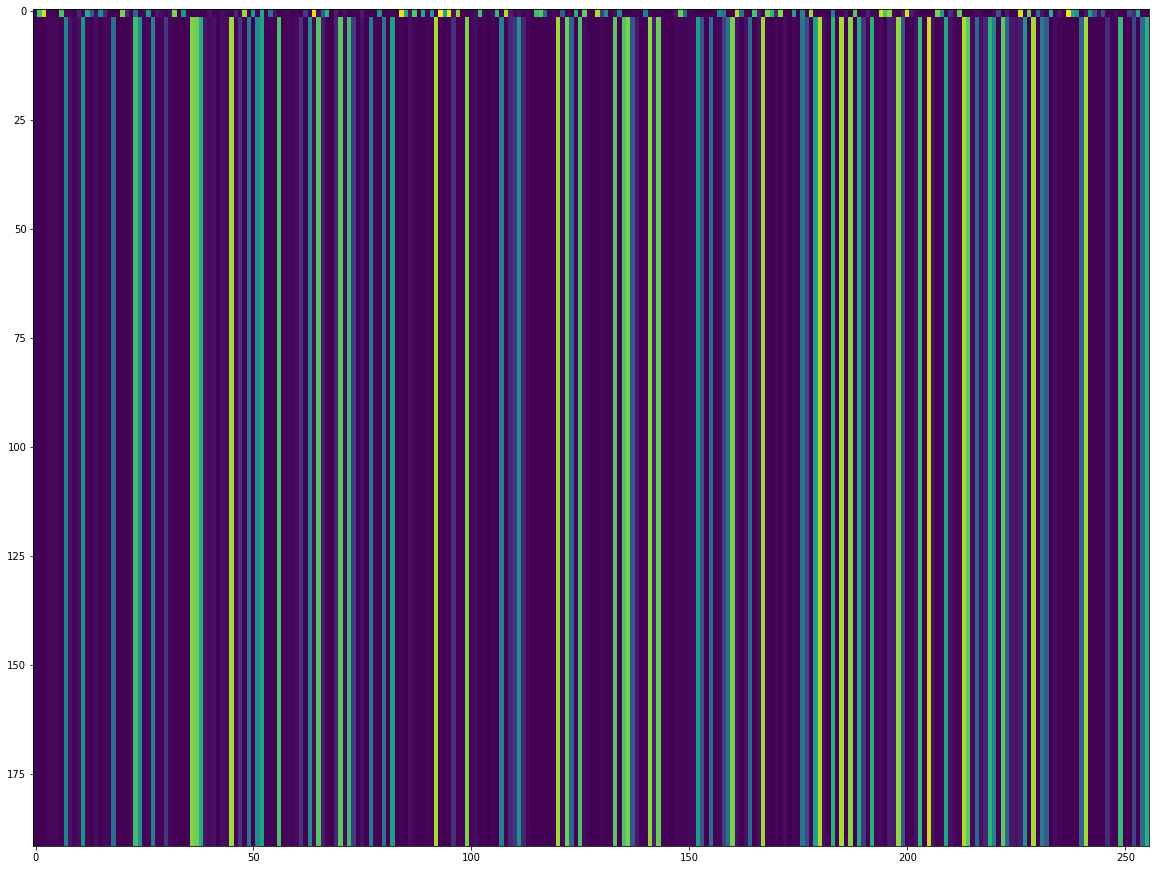

In [25]:
# generate the custome vte
c_trg = np.linspace(avg_embs[5], avg_embs[5], 192)

c_trg[:2] = avg_embs[0]

plt.figure(figsize=(20,20))
plt.imshow(c_trg)

c_trg

100%|██████████| 49152/49152 [14:10<00:00, 57.82it/s]


example0_vibrato_m8_bel002-bre190.wav


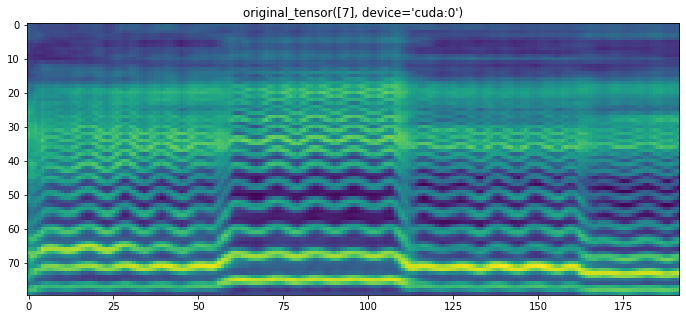

In [26]:
sys.path.insert(1, '/homes/bdoc3/my_data/autovc_data') # usually the cwd is priority, so index 1 is good enough for our purposes here
from hparams import hparams

import torch
import librosa
import soundfile as sf
import pickle
from synthesis import build_model
from synthesis import wavegen

model = build_model().to(config.device)
checkpoint = torch.load("/homes/bdoc3/my_data/autovc_data/checkpoint_step001000000_ema.pth",map_location='cpu')
model.load_state_dict(checkpoint["state_dict"])
model = model.to(config.device)

find_male = True
num_examples = 8
counter = 0

# format of metadata is (x_real, org_style_idx, singer_idx, emb_org)
metadata_list = pickle.load(open('metadata_for_synth.pkl', 'rb'))

for metadata in metadata_list[:1]:
    x_real, org_style_idx, singer_idx, emb_org = metadata
    x_real, org_style_idx, singer_idx, emb_org = x_real.to(config.device), org_style_idx.to(config.device), singer_idx.to(config.device), emb_org.to(config.device)
    emb_org_decoder = emb_org.unsqueeze(0).expand(-1,192,-1)
    all_spmels = [] #[x_real.squeeze(1)[0].cpu().detach().numpy()]
    _, x_identic_psnt, _, _, _ = G(x_real, emb_org, emb_org_decoder)
#     all_spmels.append(x_identic_psnt.squeeze(1)[0].cpu().detach().numpy())
    num_unconv_styles = 2
    if convert_style == True:
        emb_trg = torch.from_numpy(c_trg).unsqueeze(0).to(config.device).float()
        _, x_identic_psnt, _, _, _ = G(x_real, emb_org, emb_trg)
        all_spmels.append(x_identic_psnt.squeeze(1)[0].cpu().detach().numpy())

    plt.figure(figsize=(20,5))
    for j in range(len(all_spmels)):
        plt.subplot(1,len(all_spmels),j+1)
        if j == 0: plt.title('original_' +str(singer_idx))    
        else:
            try:
                plt.title(str(style_names[j-num_unconv_styles] +'_' +str(singer_idx)))
            except:
                pdb.set_trace()
        plt.imshow(np.rot90(all_spmels[j]))
    plt.savefig(subdir_for_wavs +'/example' +str(counter) +'_spmels')

    # synthesize nu shit
    for k, spmel in enumerate(all_spmels):
        waveform = wavegen(model, config.which_cuda, c=spmel)
        f_name = f'example{counter}_{style_names[org_style_idx]}_{singer_names[singer_idx]}bel002-bre190.wav'
        print(f_name)
        sf.write(subdir_for_wavs +'/' +f_name, waveform, samplerate=16000)
#         if k == 0:
#             sf.write(subdir_for_wavs +f'/example{counter}_{singer_names[singer_idx]}{style_names[org_style_idx]}_ORG.wav', waveform, samplerate=16000)
#         elif k == 1:
#             sf.write(subdir_for_wavs +f'/example{counter}_{singer_names[singer_idx]}{style_names[org_style_idx]}_synthed_from_org.wav', waveform, samplerate=16000)
#         else:
#             sf.write(subdir_for_wavs +f'/example{counter}_{singer_names[singer_idx]}{style_names[org_style_idx]}_to_{style_names[k-2]}.wav', waveform, samplerate=16000)
    counter +=1